# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
# data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

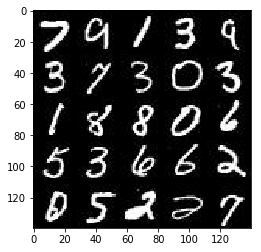

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

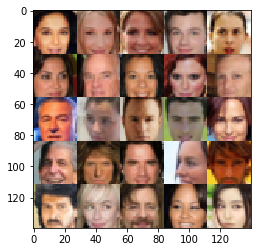

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        images = tf.image.resize_images(images, (32, 32))
        
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 16x16x64

        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 8x8x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256        

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
    
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        x1 = tf.layers.dense(z, 4*4*256)

        x1 = tf.reshape(x1, (-1, 4, 4, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 4x4x256
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 8x8x128
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 16x16x128
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # 32x32x3
        
        logits = tf.image.resize_images(logits, (28, 28))
        # 28x28x3
        
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], len(data_image_mode), z_dim)

    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])

    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

    samples, losses = [], []
    steps = 0
    print_every = 10
    show_every = 100
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Scale batch images from [-0.5, 0.5] to [-1, 1]
                batch_images = batch_images * 2
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
    
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 16, input_z, len(data_image_mode), data_image_mode)

    losses = np.array(losses)
    pyplot.plot(losses.T[0], label='Discriminator')
    pyplot.plot(losses.T[1], label='Generator')
    pyplot.title("Training Losses")
    pyplot.legend()
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.1690... Generator Loss: 2.3101
Epoch 1/2... Discriminator Loss: 1.8542... Generator Loss: 3.8825
Epoch 1/2... Discriminator Loss: 1.6443... Generator Loss: 7.3802
Epoch 1/2... Discriminator Loss: 0.3476... Generator Loss: 2.7093
Epoch 1/2... Discriminator Loss: 0.1433... Generator Loss: 2.9463
Epoch 1/2... Discriminator Loss: 0.1997... Generator Loss: 5.0372
Epoch 1/2... Discriminator Loss: 1.1570... Generator Loss: 6.2279
Epoch 1/2... Discriminator Loss: 0.4306... Generator Loss: 2.1552
Epoch 1/2... Discriminator Loss: 0.6032... Generator Loss: 3.6139
Epoch 1/2... Discriminator Loss: 1.5401... Generator Loss: 0.3704


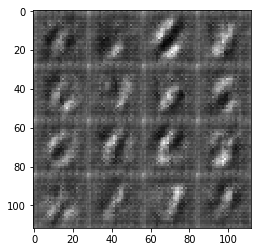

Epoch 1/2... Discriminator Loss: 0.5956... Generator Loss: 1.1029
Epoch 1/2... Discriminator Loss: 0.4844... Generator Loss: 1.3055
Epoch 1/2... Discriminator Loss: 2.0478... Generator Loss: 0.2573
Epoch 1/2... Discriminator Loss: 0.3960... Generator Loss: 1.7105
Epoch 1/2... Discriminator Loss: 0.5648... Generator Loss: 1.9405
Epoch 1/2... Discriminator Loss: 0.4846... Generator Loss: 1.6306
Epoch 1/2... Discriminator Loss: 0.4087... Generator Loss: 2.8303
Epoch 1/2... Discriminator Loss: 0.4104... Generator Loss: 1.3810
Epoch 1/2... Discriminator Loss: 0.3432... Generator Loss: 2.4639
Epoch 1/2... Discriminator Loss: 0.4038... Generator Loss: 2.3935


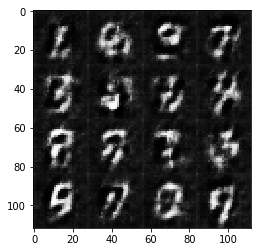

Epoch 1/2... Discriminator Loss: 0.7369... Generator Loss: 0.8472
Epoch 1/2... Discriminator Loss: 0.3825... Generator Loss: 1.7684
Epoch 1/2... Discriminator Loss: 0.8977... Generator Loss: 0.6316
Epoch 1/2... Discriminator Loss: 0.4662... Generator Loss: 2.8403
Epoch 1/2... Discriminator Loss: 0.3832... Generator Loss: 1.7494
Epoch 1/2... Discriminator Loss: 0.5360... Generator Loss: 1.9615
Epoch 1/2... Discriminator Loss: 0.3306... Generator Loss: 1.9608
Epoch 1/2... Discriminator Loss: 0.3686... Generator Loss: 2.7390
Epoch 1/2... Discriminator Loss: 0.4205... Generator Loss: 2.6608
Epoch 1/2... Discriminator Loss: 0.4371... Generator Loss: 2.8181


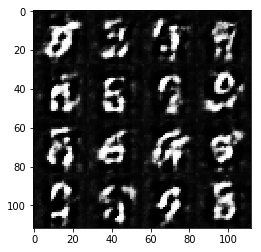

Epoch 1/2... Discriminator Loss: 0.4138... Generator Loss: 2.7800
Epoch 1/2... Discriminator Loss: 0.4477... Generator Loss: 2.3627
Epoch 1/2... Discriminator Loss: 0.3045... Generator Loss: 2.1439
Epoch 1/2... Discriminator Loss: 0.4076... Generator Loss: 1.9057
Epoch 1/2... Discriminator Loss: 0.3569... Generator Loss: 2.1515
Epoch 1/2... Discriminator Loss: 0.3585... Generator Loss: 1.9783
Epoch 1/2... Discriminator Loss: 0.3397... Generator Loss: 2.0862
Epoch 1/2... Discriminator Loss: 0.4048... Generator Loss: 2.3762
Epoch 1/2... Discriminator Loss: 0.4330... Generator Loss: 3.2399
Epoch 1/2... Discriminator Loss: 0.4457... Generator Loss: 1.5426


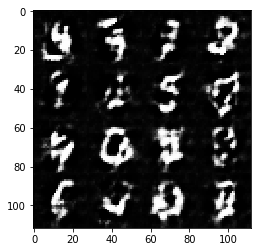

Epoch 1/2... Discriminator Loss: 0.3397... Generator Loss: 2.0523
Epoch 1/2... Discriminator Loss: 0.3471... Generator Loss: 1.9070
Epoch 1/2... Discriminator Loss: 0.3687... Generator Loss: 2.3978
Epoch 1/2... Discriminator Loss: 0.4546... Generator Loss: 1.4210
Epoch 1/2... Discriminator Loss: 0.5067... Generator Loss: 1.2250
Epoch 1/2... Discriminator Loss: 0.5948... Generator Loss: 1.1939
Epoch 1/2... Discriminator Loss: 0.3418... Generator Loss: 2.4420
Epoch 1/2... Discriminator Loss: 0.7414... Generator Loss: 0.8931
Epoch 1/2... Discriminator Loss: 0.2910... Generator Loss: 2.0181
Epoch 1/2... Discriminator Loss: 0.3747... Generator Loss: 3.0205


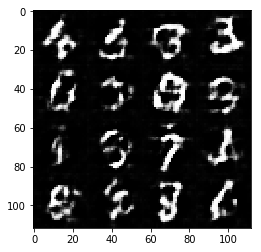

Epoch 1/2... Discriminator Loss: 0.7338... Generator Loss: 0.8907
Epoch 1/2... Discriminator Loss: 0.2659... Generator Loss: 3.1896
Epoch 1/2... Discriminator Loss: 0.5725... Generator Loss: 1.1398
Epoch 1/2... Discriminator Loss: 0.6336... Generator Loss: 1.0812
Epoch 1/2... Discriminator Loss: 0.4721... Generator Loss: 1.3775
Epoch 1/2... Discriminator Loss: 0.4325... Generator Loss: 2.0238
Epoch 1/2... Discriminator Loss: 0.9560... Generator Loss: 4.3632
Epoch 1/2... Discriminator Loss: 0.5329... Generator Loss: 2.6885
Epoch 1/2... Discriminator Loss: 0.6853... Generator Loss: 0.9444
Epoch 1/2... Discriminator Loss: 0.3532... Generator Loss: 2.1308


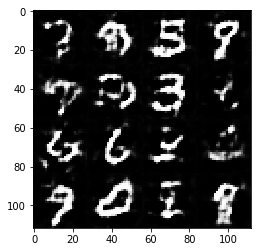

Epoch 1/2... Discriminator Loss: 0.4957... Generator Loss: 1.4611
Epoch 1/2... Discriminator Loss: 0.3741... Generator Loss: 2.1303
Epoch 1/2... Discriminator Loss: 0.5973... Generator Loss: 3.0825
Epoch 1/2... Discriminator Loss: 0.5444... Generator Loss: 1.2393
Epoch 1/2... Discriminator Loss: 0.5335... Generator Loss: 1.2771
Epoch 1/2... Discriminator Loss: 0.6439... Generator Loss: 3.2012
Epoch 1/2... Discriminator Loss: 0.9725... Generator Loss: 0.6150
Epoch 1/2... Discriminator Loss: 0.3161... Generator Loss: 2.0434
Epoch 1/2... Discriminator Loss: 0.4609... Generator Loss: 1.4240
Epoch 1/2... Discriminator Loss: 0.5516... Generator Loss: 2.6902


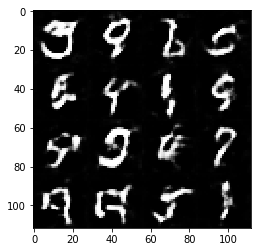

Epoch 1/2... Discriminator Loss: 0.7184... Generator Loss: 0.8965
Epoch 1/2... Discriminator Loss: 0.5048... Generator Loss: 1.2924
Epoch 1/2... Discriminator Loss: 3.0111... Generator Loss: 0.1250
Epoch 1/2... Discriminator Loss: 0.6713... Generator Loss: 1.0968
Epoch 1/2... Discriminator Loss: 0.4230... Generator Loss: 1.7733
Epoch 1/2... Discriminator Loss: 0.5062... Generator Loss: 1.7122
Epoch 1/2... Discriminator Loss: 0.4909... Generator Loss: 1.5897
Epoch 1/2... Discriminator Loss: 0.3316... Generator Loss: 2.2306
Epoch 1/2... Discriminator Loss: 0.5302... Generator Loss: 1.2230
Epoch 1/2... Discriminator Loss: 0.5132... Generator Loss: 1.3919


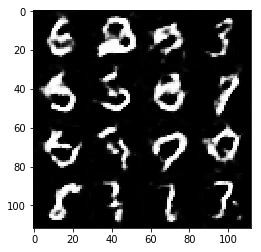

Epoch 1/2... Discriminator Loss: 1.3918... Generator Loss: 5.0550
Epoch 1/2... Discriminator Loss: 0.6195... Generator Loss: 2.2009
Epoch 1/2... Discriminator Loss: 0.4222... Generator Loss: 1.6972
Epoch 1/2... Discriminator Loss: 0.4538... Generator Loss: 1.9640
Epoch 1/2... Discriminator Loss: 0.3862... Generator Loss: 1.8619
Epoch 1/2... Discriminator Loss: 0.3802... Generator Loss: 1.6380
Epoch 1/2... Discriminator Loss: 0.8678... Generator Loss: 0.7559
Epoch 1/2... Discriminator Loss: 0.4447... Generator Loss: 2.1059
Epoch 1/2... Discriminator Loss: 0.3566... Generator Loss: 2.0028
Epoch 1/2... Discriminator Loss: 0.4917... Generator Loss: 1.3034


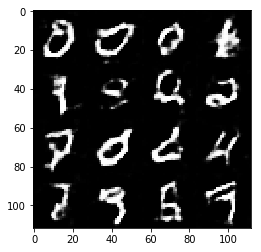

Epoch 1/2... Discriminator Loss: 0.5416... Generator Loss: 2.2529
Epoch 1/2... Discriminator Loss: 0.4140... Generator Loss: 2.7796
Epoch 1/2... Discriminator Loss: 0.3938... Generator Loss: 1.6756
Epoch 2/2... Discriminator Loss: 0.5392... Generator Loss: 1.1514
Epoch 2/2... Discriminator Loss: 1.0807... Generator Loss: 0.5479
Epoch 2/2... Discriminator Loss: 0.7417... Generator Loss: 1.2041
Epoch 2/2... Discriminator Loss: 0.6901... Generator Loss: 1.1738
Epoch 2/2... Discriminator Loss: 0.5125... Generator Loss: 1.4716
Epoch 2/2... Discriminator Loss: 0.6956... Generator Loss: 1.0489
Epoch 2/2... Discriminator Loss: 0.7396... Generator Loss: 0.8442


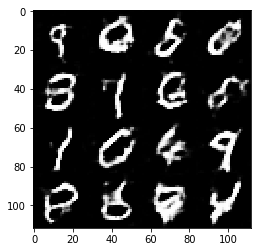

Epoch 2/2... Discriminator Loss: 0.3699... Generator Loss: 1.7196
Epoch 2/2... Discriminator Loss: 0.3778... Generator Loss: 1.7261
Epoch 2/2... Discriminator Loss: 0.3347... Generator Loss: 1.9228
Epoch 2/2... Discriminator Loss: 0.5568... Generator Loss: 1.1337
Epoch 2/2... Discriminator Loss: 0.5136... Generator Loss: 1.3901
Epoch 2/2... Discriminator Loss: 0.3116... Generator Loss: 1.8686
Epoch 2/2... Discriminator Loss: 0.3902... Generator Loss: 1.9737
Epoch 2/2... Discriminator Loss: 0.3424... Generator Loss: 1.8713
Epoch 2/2... Discriminator Loss: 0.4048... Generator Loss: 1.6830
Epoch 2/2... Discriminator Loss: 0.3388... Generator Loss: 1.6408


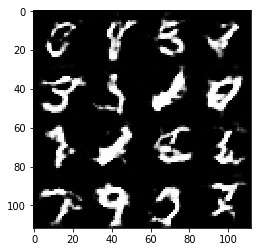

Epoch 2/2... Discriminator Loss: 0.3451... Generator Loss: 1.8290
Epoch 2/2... Discriminator Loss: 0.5192... Generator Loss: 1.3007
Epoch 2/2... Discriminator Loss: 1.0436... Generator Loss: 0.9322
Epoch 2/2... Discriminator Loss: 0.7205... Generator Loss: 1.0106
Epoch 2/2... Discriminator Loss: 0.5725... Generator Loss: 1.4280
Epoch 2/2... Discriminator Loss: 0.5136... Generator Loss: 1.2920
Epoch 2/2... Discriminator Loss: 0.4596... Generator Loss: 1.3666
Epoch 2/2... Discriminator Loss: 0.4269... Generator Loss: 1.9704
Epoch 2/2... Discriminator Loss: 0.4741... Generator Loss: 1.2467
Epoch 2/2... Discriminator Loss: 0.3722... Generator Loss: 1.5545


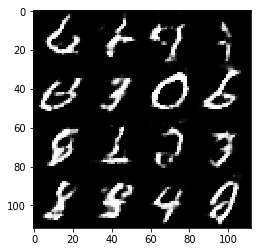

Epoch 2/2... Discriminator Loss: 0.4314... Generator Loss: 1.4574
Epoch 2/2... Discriminator Loss: 0.5884... Generator Loss: 1.1057
Epoch 2/2... Discriminator Loss: 0.5522... Generator Loss: 1.1925
Epoch 2/2... Discriminator Loss: 0.4940... Generator Loss: 1.3243
Epoch 2/2... Discriminator Loss: 0.4914... Generator Loss: 1.2037
Epoch 2/2... Discriminator Loss: 0.3213... Generator Loss: 1.8862
Epoch 2/2... Discriminator Loss: 3.5192... Generator Loss: 0.0759
Epoch 2/2... Discriminator Loss: 0.9450... Generator Loss: 0.8867
Epoch 2/2... Discriminator Loss: 0.8755... Generator Loss: 0.9923
Epoch 2/2... Discriminator Loss: 0.9367... Generator Loss: 0.7092


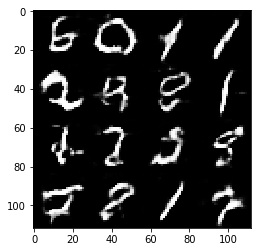

Epoch 2/2... Discriminator Loss: 0.4935... Generator Loss: 1.3625
Epoch 2/2... Discriminator Loss: 0.3421... Generator Loss: 2.1018
Epoch 2/2... Discriminator Loss: 0.5105... Generator Loss: 1.2793
Epoch 2/2... Discriminator Loss: 0.4969... Generator Loss: 1.2808
Epoch 2/2... Discriminator Loss: 0.4338... Generator Loss: 2.6013
Epoch 2/2... Discriminator Loss: 0.6042... Generator Loss: 0.9992
Epoch 2/2... Discriminator Loss: 0.7687... Generator Loss: 0.9242
Epoch 2/2... Discriminator Loss: 0.7791... Generator Loss: 1.2521
Epoch 2/2... Discriminator Loss: 0.5960... Generator Loss: 1.3911
Epoch 2/2... Discriminator Loss: 0.6062... Generator Loss: 1.2039


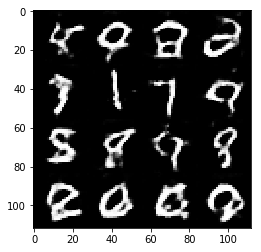

Epoch 2/2... Discriminator Loss: 0.5099... Generator Loss: 1.2296
Epoch 2/2... Discriminator Loss: 0.3933... Generator Loss: 1.4538
Epoch 2/2... Discriminator Loss: 0.4974... Generator Loss: 1.3215
Epoch 2/2... Discriminator Loss: 0.4459... Generator Loss: 1.5335
Epoch 2/2... Discriminator Loss: 0.3072... Generator Loss: 1.7436
Epoch 2/2... Discriminator Loss: 0.4162... Generator Loss: 1.5565
Epoch 2/2... Discriminator Loss: 0.6516... Generator Loss: 1.0615
Epoch 2/2... Discriminator Loss: 0.4359... Generator Loss: 1.5040
Epoch 2/2... Discriminator Loss: 2.2513... Generator Loss: 4.6923
Epoch 2/2... Discriminator Loss: 0.5579... Generator Loss: 1.8919


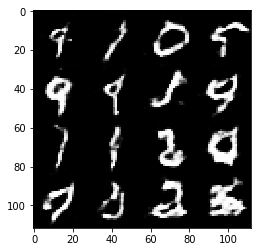

Epoch 2/2... Discriminator Loss: 1.4361... Generator Loss: 0.4521
Epoch 2/2... Discriminator Loss: 0.6532... Generator Loss: 1.2530
Epoch 2/2... Discriminator Loss: 0.6942... Generator Loss: 1.1425
Epoch 2/2... Discriminator Loss: 0.6391... Generator Loss: 1.1484
Epoch 2/2... Discriminator Loss: 0.5516... Generator Loss: 1.2124
Epoch 2/2... Discriminator Loss: 1.2992... Generator Loss: 0.4560
Epoch 2/2... Discriminator Loss: 0.5218... Generator Loss: 1.2680
Epoch 2/2... Discriminator Loss: 0.4610... Generator Loss: 1.4767
Epoch 2/2... Discriminator Loss: 0.4347... Generator Loss: 1.4095
Epoch 2/2... Discriminator Loss: 0.5703... Generator Loss: 1.1599


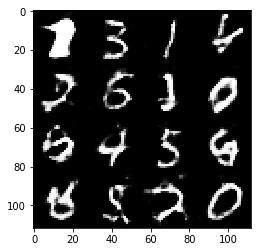

Epoch 2/2... Discriminator Loss: 0.5691... Generator Loss: 1.1520
Epoch 2/2... Discriminator Loss: 0.9325... Generator Loss: 0.7215
Epoch 2/2... Discriminator Loss: 0.4133... Generator Loss: 1.4451
Epoch 2/2... Discriminator Loss: 0.3549... Generator Loss: 1.8864
Epoch 2/2... Discriminator Loss: 0.6790... Generator Loss: 1.0467
Epoch 2/2... Discriminator Loss: 0.4145... Generator Loss: 1.6837
Epoch 2/2... Discriminator Loss: 0.7572... Generator Loss: 1.0133
Epoch 2/2... Discriminator Loss: 0.7365... Generator Loss: 2.6208
Epoch 2/2... Discriminator Loss: 0.3955... Generator Loss: 1.7030
Epoch 2/2... Discriminator Loss: 0.3699... Generator Loss: 1.5510


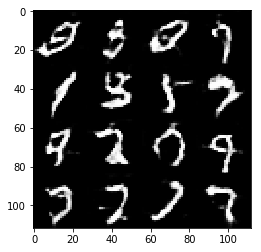

Epoch 2/2... Discriminator Loss: 0.3066... Generator Loss: 1.7999
Epoch 2/2... Discriminator Loss: 0.4923... Generator Loss: 1.3041
Epoch 2/2... Discriminator Loss: 0.4311... Generator Loss: 1.4204
Epoch 2/2... Discriminator Loss: 0.4967... Generator Loss: 1.2732
Epoch 2/2... Discriminator Loss: 0.3791... Generator Loss: 1.7564
Epoch 2/2... Discriminator Loss: 0.4900... Generator Loss: 2.2874
Epoch 2/2... Discriminator Loss: 0.9775... Generator Loss: 2.1876
Epoch 2/2... Discriminator Loss: 0.8027... Generator Loss: 1.2933
Epoch 2/2... Discriminator Loss: 0.5504... Generator Loss: 1.6380
Epoch 2/2... Discriminator Loss: 1.5441... Generator Loss: 0.3874


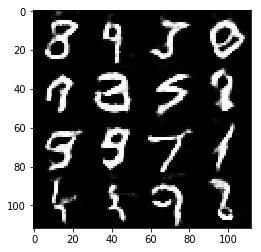

Epoch 2/2... Discriminator Loss: 0.5966... Generator Loss: 1.2942
Epoch 2/2... Discriminator Loss: 0.5796... Generator Loss: 1.1300
Epoch 2/2... Discriminator Loss: 0.6169... Generator Loss: 1.2036
Epoch 2/2... Discriminator Loss: 0.4341... Generator Loss: 1.7033
Epoch 2/2... Discriminator Loss: 0.4531... Generator Loss: 1.5760
Epoch 2/2... Discriminator Loss: 0.6532... Generator Loss: 1.2869
Epoch 2/2... Discriminator Loss: 0.4560... Generator Loss: 2.0933


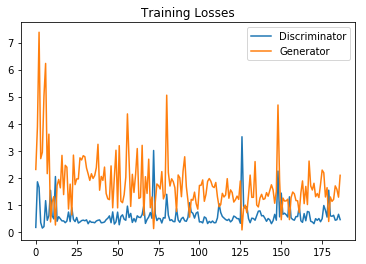

In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/3... Discriminator Loss: 0.2565... Generator Loss: 2.1349
Epoch 1/3... Discriminator Loss: 0.2819... Generator Loss: 2.0940
Epoch 1/3... Discriminator Loss: 0.1205... Generator Loss: 4.9467
Epoch 1/3... Discriminator Loss: 4.1174... Generator Loss: 12.2124
Epoch 1/3... Discriminator Loss: 0.4920... Generator Loss: 1.9032
Epoch 1/3... Discriminator Loss: 0.6478... Generator Loss: 1.5331
Epoch 1/3... Discriminator Loss: 0.5747... Generator Loss: 1.6102
Epoch 1/3... Discriminator Loss: 0.7377... Generator Loss: 2.4965
Epoch 1/3... Discriminator Loss: 1.0692... Generator Loss: 0.6779
Epoch 1/3... Discriminator Loss: 1.4802... Generator Loss: 4.7798


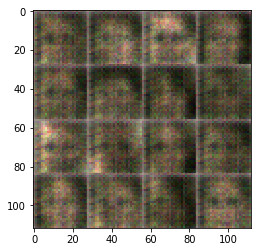

Epoch 1/3... Discriminator Loss: 0.5393... Generator Loss: 2.2726
Epoch 1/3... Discriminator Loss: 1.1229... Generator Loss: 0.6436
Epoch 1/3... Discriminator Loss: 1.2984... Generator Loss: 0.6115
Epoch 1/3... Discriminator Loss: 0.4113... Generator Loss: 2.0864
Epoch 1/3... Discriminator Loss: 0.6798... Generator Loss: 1.2898
Epoch 1/3... Discriminator Loss: 0.7748... Generator Loss: 1.3428
Epoch 1/3... Discriminator Loss: 1.0098... Generator Loss: 0.8570
Epoch 1/3... Discriminator Loss: 0.5316... Generator Loss: 1.5306
Epoch 1/3... Discriminator Loss: 0.6007... Generator Loss: 1.5898
Epoch 1/3... Discriminator Loss: 0.6309... Generator Loss: 1.2271


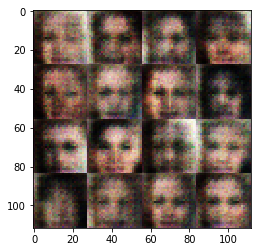

Epoch 1/3... Discriminator Loss: 1.1189... Generator Loss: 0.5693
Epoch 1/3... Discriminator Loss: 0.9376... Generator Loss: 0.7388
Epoch 1/3... Discriminator Loss: 0.5841... Generator Loss: 1.3250
Epoch 1/3... Discriminator Loss: 1.0809... Generator Loss: 3.4529
Epoch 1/3... Discriminator Loss: 0.7667... Generator Loss: 1.4252
Epoch 1/3... Discriminator Loss: 0.4979... Generator Loss: 1.6526
Epoch 1/3... Discriminator Loss: 0.8983... Generator Loss: 0.9275
Epoch 1/3... Discriminator Loss: 0.7766... Generator Loss: 1.0428
Epoch 1/3... Discriminator Loss: 0.4318... Generator Loss: 2.3052
Epoch 1/3... Discriminator Loss: 0.7881... Generator Loss: 0.9770


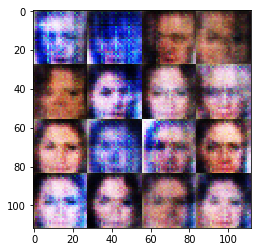

Epoch 1/3... Discriminator Loss: 0.6293... Generator Loss: 1.7953
Epoch 1/3... Discriminator Loss: 0.7242... Generator Loss: 1.7508
Epoch 1/3... Discriminator Loss: 0.8725... Generator Loss: 1.2215
Epoch 1/3... Discriminator Loss: 0.9690... Generator Loss: 0.9901
Epoch 1/3... Discriminator Loss: 1.0850... Generator Loss: 0.7118
Epoch 1/3... Discriminator Loss: 1.3723... Generator Loss: 2.7364
Epoch 1/3... Discriminator Loss: 0.8610... Generator Loss: 1.4181
Epoch 1/3... Discriminator Loss: 0.8324... Generator Loss: 1.3262
Epoch 1/3... Discriminator Loss: 0.8905... Generator Loss: 1.4984
Epoch 1/3... Discriminator Loss: 1.1298... Generator Loss: 0.7050


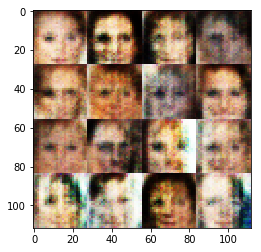

Epoch 1/3... Discriminator Loss: 1.2710... Generator Loss: 1.1946
Epoch 1/3... Discriminator Loss: 0.8851... Generator Loss: 1.4599
Epoch 1/3... Discriminator Loss: 0.7133... Generator Loss: 1.7831
Epoch 1/3... Discriminator Loss: 0.8676... Generator Loss: 0.9552
Epoch 1/3... Discriminator Loss: 0.8179... Generator Loss: 0.9764
Epoch 1/3... Discriminator Loss: 1.1243... Generator Loss: 1.8886
Epoch 1/3... Discriminator Loss: 0.7277... Generator Loss: 1.5670
Epoch 1/3... Discriminator Loss: 0.8816... Generator Loss: 0.9871
Epoch 1/3... Discriminator Loss: 0.8815... Generator Loss: 0.9145


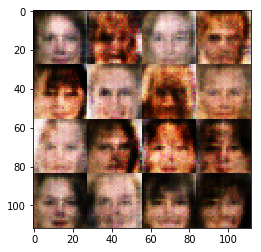

Epoch 1/3... Discriminator Loss: 0.7623... Generator Loss: 1.2201
Epoch 1/3... Discriminator Loss: 0.6788... Generator Loss: 1.7610
Epoch 1/3... Discriminator Loss: 0.7929... Generator Loss: 1.4951
Epoch 1/3... Discriminator Loss: 0.5660... Generator Loss: 1.9460
Epoch 1/3... Discriminator Loss: 0.9449... Generator Loss: 1.4340
Epoch 1/3... Discriminator Loss: 0.8983... Generator Loss: 1.7838
Epoch 1/3... Discriminator Loss: 0.7862... Generator Loss: 1.6417
Epoch 1/3... Discriminator Loss: 0.8154... Generator Loss: 0.9660
Epoch 1/3... Discriminator Loss: 0.9833... Generator Loss: 0.7691
Epoch 1/3... Discriminator Loss: 1.0125... Generator Loss: 1.3303


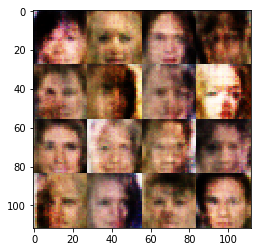

Epoch 1/3... Discriminator Loss: 0.9466... Generator Loss: 0.7597
Epoch 1/3... Discriminator Loss: 1.0705... Generator Loss: 1.2661
Epoch 1/3... Discriminator Loss: 0.8941... Generator Loss: 1.4660
Epoch 1/3... Discriminator Loss: 1.0002... Generator Loss: 1.6478
Epoch 1/3... Discriminator Loss: 0.9985... Generator Loss: 1.0825
Epoch 1/3... Discriminator Loss: 0.8402... Generator Loss: 0.9351
Epoch 1/3... Discriminator Loss: 0.9455... Generator Loss: 0.8553
Epoch 1/3... Discriminator Loss: 0.9472... Generator Loss: 1.6938
Epoch 1/3... Discriminator Loss: 1.1134... Generator Loss: 0.6265
Epoch 1/3... Discriminator Loss: 0.9715... Generator Loss: 1.5959


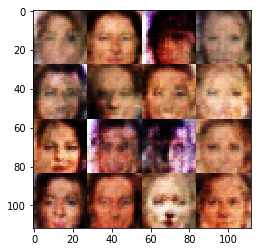

Epoch 1/3... Discriminator Loss: 0.9193... Generator Loss: 1.5142
Epoch 1/3... Discriminator Loss: 0.9104... Generator Loss: 1.4376
Epoch 1/3... Discriminator Loss: 0.9576... Generator Loss: 0.8886
Epoch 1/3... Discriminator Loss: 0.9081... Generator Loss: 0.8862
Epoch 1/3... Discriminator Loss: 0.7609... Generator Loss: 1.6823
Epoch 1/3... Discriminator Loss: 0.8696... Generator Loss: 0.9269
Epoch 1/3... Discriminator Loss: 0.9326... Generator Loss: 2.1803
Epoch 1/3... Discriminator Loss: 0.7243... Generator Loss: 1.5147
Epoch 1/3... Discriminator Loss: 0.8307... Generator Loss: 1.2252
Epoch 1/3... Discriminator Loss: 0.9493... Generator Loss: 1.9923


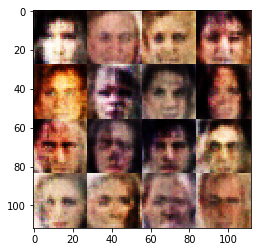

Epoch 1/3... Discriminator Loss: 0.6869... Generator Loss: 1.5845
Epoch 1/3... Discriminator Loss: 0.7427... Generator Loss: 1.2225
Epoch 1/3... Discriminator Loss: 0.7023... Generator Loss: 1.0655
Epoch 1/3... Discriminator Loss: 0.6135... Generator Loss: 1.3521
Epoch 1/3... Discriminator Loss: 0.7656... Generator Loss: 1.0717
Epoch 1/3... Discriminator Loss: 0.7575... Generator Loss: 1.1196
Epoch 1/3... Discriminator Loss: 0.9548... Generator Loss: 0.7793
Epoch 1/3... Discriminator Loss: 0.9204... Generator Loss: 0.9818
Epoch 1/3... Discriminator Loss: 0.8241... Generator Loss: 0.9755
Epoch 1/3... Discriminator Loss: 0.9112... Generator Loss: 0.9033


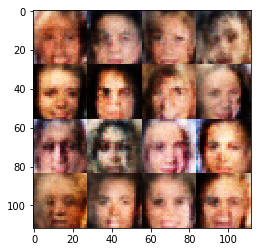

Epoch 1/3... Discriminator Loss: 0.7081... Generator Loss: 1.2675
Epoch 1/3... Discriminator Loss: 0.5773... Generator Loss: 1.5330
Epoch 1/3... Discriminator Loss: 0.9794... Generator Loss: 1.0158
Epoch 1/3... Discriminator Loss: 1.0642... Generator Loss: 1.5530
Epoch 1/3... Discriminator Loss: 0.9586... Generator Loss: 0.7587
Epoch 1/3... Discriminator Loss: 0.9856... Generator Loss: 0.7365
Epoch 1/3... Discriminator Loss: 0.6913... Generator Loss: 1.7157
Epoch 1/3... Discriminator Loss: 0.9841... Generator Loss: 1.9727
Epoch 1/3... Discriminator Loss: 0.7664... Generator Loss: 0.9777
Epoch 1/3... Discriminator Loss: 0.8484... Generator Loss: 0.9700


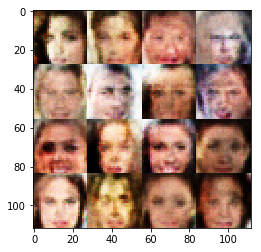

Epoch 1/3... Discriminator Loss: 0.7083... Generator Loss: 1.0481
Epoch 1/3... Discriminator Loss: 0.6871... Generator Loss: 1.5673
Epoch 1/3... Discriminator Loss: 0.8706... Generator Loss: 0.8480
Epoch 1/3... Discriminator Loss: 0.8244... Generator Loss: 1.9403
Epoch 1/3... Discriminator Loss: 1.4247... Generator Loss: 0.4630
Epoch 1/3... Discriminator Loss: 0.8582... Generator Loss: 0.9985
Epoch 1/3... Discriminator Loss: 0.9380... Generator Loss: 0.8471
Epoch 1/3... Discriminator Loss: 0.5566... Generator Loss: 1.6761
Epoch 1/3... Discriminator Loss: 0.9116... Generator Loss: 0.9482
Epoch 1/3... Discriminator Loss: 0.9870... Generator Loss: 0.7520


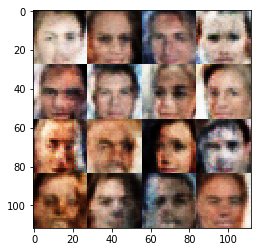

Epoch 1/3... Discriminator Loss: 1.0146... Generator Loss: 0.6338
Epoch 1/3... Discriminator Loss: 0.8824... Generator Loss: 1.5977
Epoch 1/3... Discriminator Loss: 0.7194... Generator Loss: 1.9246
Epoch 1/3... Discriminator Loss: 0.7523... Generator Loss: 1.1655
Epoch 1/3... Discriminator Loss: 0.7852... Generator Loss: 2.6396
Epoch 1/3... Discriminator Loss: 0.8107... Generator Loss: 1.0082
Epoch 1/3... Discriminator Loss: 0.8886... Generator Loss: 0.9375
Epoch 1/3... Discriminator Loss: 0.9751... Generator Loss: 0.8973
Epoch 1/3... Discriminator Loss: 0.6299... Generator Loss: 1.6323
Epoch 1/3... Discriminator Loss: 0.8446... Generator Loss: 0.9236


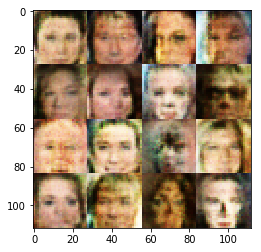

Epoch 1/3... Discriminator Loss: 1.0512... Generator Loss: 2.0546
Epoch 1/3... Discriminator Loss: 1.1177... Generator Loss: 2.2720
Epoch 1/3... Discriminator Loss: 1.1869... Generator Loss: 0.5519
Epoch 1/3... Discriminator Loss: 0.6905... Generator Loss: 1.2912
Epoch 1/3... Discriminator Loss: 0.8179... Generator Loss: 0.9396
Epoch 1/3... Discriminator Loss: 0.8716... Generator Loss: 0.8160
Epoch 1/3... Discriminator Loss: 1.4290... Generator Loss: 2.0411
Epoch 1/3... Discriminator Loss: 1.1053... Generator Loss: 0.9414
Epoch 1/3... Discriminator Loss: 0.9325... Generator Loss: 0.8890
Epoch 1/3... Discriminator Loss: 1.0053... Generator Loss: 0.7216


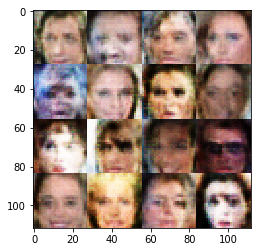

Epoch 1/3... Discriminator Loss: 0.6596... Generator Loss: 1.5005
Epoch 1/3... Discriminator Loss: 0.6969... Generator Loss: 1.4510
Epoch 1/3... Discriminator Loss: 0.8109... Generator Loss: 0.9805
Epoch 1/3... Discriminator Loss: 0.9338... Generator Loss: 0.6822
Epoch 1/3... Discriminator Loss: 1.4400... Generator Loss: 0.3733
Epoch 1/3... Discriminator Loss: 0.9568... Generator Loss: 1.2706
Epoch 1/3... Discriminator Loss: 0.6541... Generator Loss: 1.7512
Epoch 1/3... Discriminator Loss: 0.7603... Generator Loss: 1.1576
Epoch 1/3... Discriminator Loss: 0.7714... Generator Loss: 0.9734
Epoch 1/3... Discriminator Loss: 0.9946... Generator Loss: 0.6606


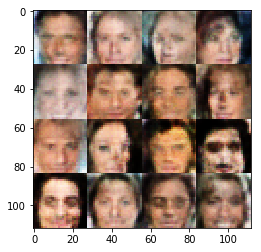

Epoch 1/3... Discriminator Loss: 0.8255... Generator Loss: 0.8828
Epoch 1/3... Discriminator Loss: 0.9752... Generator Loss: 2.2265
Epoch 1/3... Discriminator Loss: 0.7526... Generator Loss: 1.0803
Epoch 1/3... Discriminator Loss: 1.2382... Generator Loss: 0.5386
Epoch 1/3... Discriminator Loss: 0.8600... Generator Loss: 0.9139
Epoch 1/3... Discriminator Loss: 0.7488... Generator Loss: 1.4172
Epoch 1/3... Discriminator Loss: 0.8194... Generator Loss: 1.4507
Epoch 1/3... Discriminator Loss: 0.6719... Generator Loss: 1.4095
Epoch 1/3... Discriminator Loss: 0.7474... Generator Loss: 1.0666
Epoch 1/3... Discriminator Loss: 0.8927... Generator Loss: 1.6753


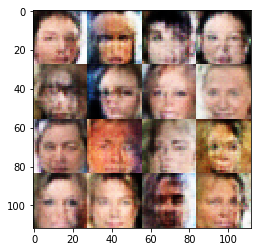

Epoch 1/3... Discriminator Loss: 0.7743... Generator Loss: 1.0445
Epoch 1/3... Discriminator Loss: 0.6859... Generator Loss: 1.2005
Epoch 1/3... Discriminator Loss: 0.8633... Generator Loss: 2.0911
Epoch 1/3... Discriminator Loss: 0.9594... Generator Loss: 2.0773
Epoch 1/3... Discriminator Loss: 1.0302... Generator Loss: 1.7774
Epoch 1/3... Discriminator Loss: 0.7204... Generator Loss: 1.0434
Epoch 1/3... Discriminator Loss: 0.7017... Generator Loss: 1.8547
Epoch 1/3... Discriminator Loss: 0.8506... Generator Loss: 0.9038
Epoch 2/3... Discriminator Loss: 1.7591... Generator Loss: 0.2694
Epoch 2/3... Discriminator Loss: 0.7101... Generator Loss: 1.3129


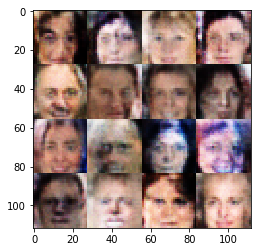

Epoch 2/3... Discriminator Loss: 0.7281... Generator Loss: 1.0988
Epoch 2/3... Discriminator Loss: 0.8167... Generator Loss: 0.9981
Epoch 2/3... Discriminator Loss: 0.7950... Generator Loss: 0.9697
Epoch 2/3... Discriminator Loss: 0.4923... Generator Loss: 2.1231
Epoch 2/3... Discriminator Loss: 0.7203... Generator Loss: 1.1151
Epoch 2/3... Discriminator Loss: 0.6695... Generator Loss: 1.8448
Epoch 2/3... Discriminator Loss: 0.7967... Generator Loss: 1.3255
Epoch 2/3... Discriminator Loss: 0.6686... Generator Loss: 1.1686
Epoch 2/3... Discriminator Loss: 0.7650... Generator Loss: 1.0740
Epoch 2/3... Discriminator Loss: 0.9421... Generator Loss: 1.2921


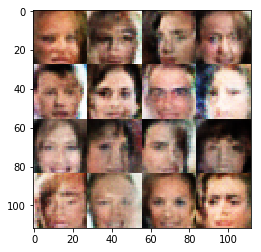

Epoch 2/3... Discriminator Loss: 0.7142... Generator Loss: 1.7874
Epoch 2/3... Discriminator Loss: 0.7089... Generator Loss: 1.4229
Epoch 2/3... Discriminator Loss: 1.0942... Generator Loss: 1.9610
Epoch 2/3... Discriminator Loss: 0.7701... Generator Loss: 1.0713
Epoch 2/3... Discriminator Loss: 0.9323... Generator Loss: 1.5561
Epoch 2/3... Discriminator Loss: 0.6961... Generator Loss: 2.1844
Epoch 2/3... Discriminator Loss: 0.5397... Generator Loss: 1.4646
Epoch 2/3... Discriminator Loss: 0.7849... Generator Loss: 1.2135
Epoch 2/3... Discriminator Loss: 0.7983... Generator Loss: 1.2420
Epoch 2/3... Discriminator Loss: 0.8292... Generator Loss: 1.0092


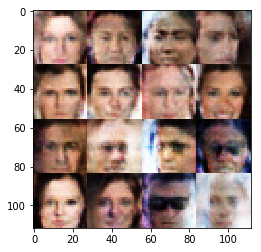

Epoch 2/3... Discriminator Loss: 0.7033... Generator Loss: 1.3290
Epoch 2/3... Discriminator Loss: 0.7807... Generator Loss: 0.9884
Epoch 2/3... Discriminator Loss: 0.8256... Generator Loss: 1.1499
Epoch 2/3... Discriminator Loss: 0.6112... Generator Loss: 1.4195
Epoch 2/3... Discriminator Loss: 0.5492... Generator Loss: 1.8668
Epoch 2/3... Discriminator Loss: 0.7683... Generator Loss: 1.4158
Epoch 2/3... Discriminator Loss: 0.5693... Generator Loss: 1.7650
Epoch 2/3... Discriminator Loss: 0.7721... Generator Loss: 1.0319
Epoch 2/3... Discriminator Loss: 0.9582... Generator Loss: 0.8998
Epoch 2/3... Discriminator Loss: 0.8422... Generator Loss: 1.0648


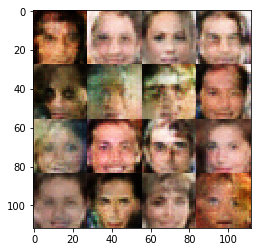

Epoch 2/3... Discriminator Loss: 0.8934... Generator Loss: 0.7392
Epoch 2/3... Discriminator Loss: 0.9517... Generator Loss: 1.1783
Epoch 2/3... Discriminator Loss: 1.8439... Generator Loss: 0.2606
Epoch 2/3... Discriminator Loss: 0.7437... Generator Loss: 1.0660
Epoch 2/3... Discriminator Loss: 0.6174... Generator Loss: 1.5083
Epoch 2/3... Discriminator Loss: 0.8908... Generator Loss: 1.7784
Epoch 2/3... Discriminator Loss: 0.6721... Generator Loss: 1.2236
Epoch 2/3... Discriminator Loss: 0.8480... Generator Loss: 1.4390
Epoch 2/3... Discriminator Loss: 0.6129... Generator Loss: 1.6461
Epoch 2/3... Discriminator Loss: 0.7315... Generator Loss: 1.1615


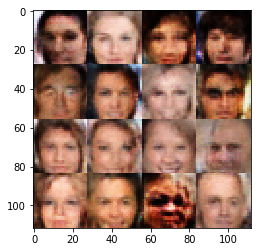

Epoch 2/3... Discriminator Loss: 0.8114... Generator Loss: 1.0873
Epoch 2/3... Discriminator Loss: 0.9872... Generator Loss: 0.6870
Epoch 2/3... Discriminator Loss: 0.6791... Generator Loss: 1.1695
Epoch 2/3... Discriminator Loss: 0.6795... Generator Loss: 1.1549
Epoch 2/3... Discriminator Loss: 0.7701... Generator Loss: 1.1646
Epoch 2/3... Discriminator Loss: 1.1502... Generator Loss: 0.5211
Epoch 2/3... Discriminator Loss: 0.8529... Generator Loss: 0.8978
Epoch 2/3... Discriminator Loss: 0.9401... Generator Loss: 0.7002
Epoch 2/3... Discriminator Loss: 0.7114... Generator Loss: 1.1507
Epoch 2/3... Discriminator Loss: 0.7699... Generator Loss: 1.0205


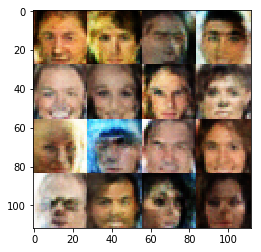

Epoch 2/3... Discriminator Loss: 1.0880... Generator Loss: 0.5684
Epoch 2/3... Discriminator Loss: 0.5665... Generator Loss: 1.3488
Epoch 2/3... Discriminator Loss: 1.2931... Generator Loss: 0.4771
Epoch 2/3... Discriminator Loss: 0.6426... Generator Loss: 2.2847
Epoch 2/3... Discriminator Loss: 0.7119... Generator Loss: 1.0515
Epoch 2/3... Discriminator Loss: 0.7352... Generator Loss: 2.0836
Epoch 2/3... Discriminator Loss: 0.7331... Generator Loss: 1.2127
Epoch 2/3... Discriminator Loss: 0.7626... Generator Loss: 0.8675
Epoch 2/3... Discriminator Loss: 1.2846... Generator Loss: 2.5016
Epoch 2/3... Discriminator Loss: 0.9135... Generator Loss: 0.7510


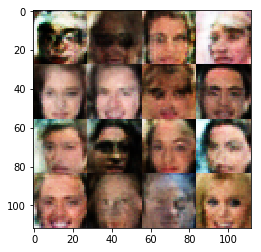

Epoch 2/3... Discriminator Loss: 0.8898... Generator Loss: 1.1431
Epoch 2/3... Discriminator Loss: 0.7369... Generator Loss: 1.4128
Epoch 2/3... Discriminator Loss: 0.7744... Generator Loss: 0.9548
Epoch 2/3... Discriminator Loss: 0.9360... Generator Loss: 1.0310
Epoch 2/3... Discriminator Loss: 1.3559... Generator Loss: 0.4074
Epoch 2/3... Discriminator Loss: 0.8036... Generator Loss: 1.2788
Epoch 2/3... Discriminator Loss: 0.8507... Generator Loss: 0.8592
Epoch 2/3... Discriminator Loss: 0.6376... Generator Loss: 1.8658
Epoch 2/3... Discriminator Loss: 0.7775... Generator Loss: 1.1862
Epoch 2/3... Discriminator Loss: 0.8822... Generator Loss: 2.3306


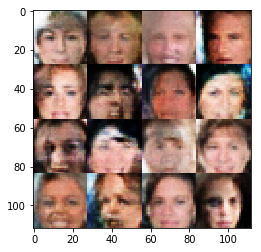

Epoch 2/3... Discriminator Loss: 0.8050... Generator Loss: 1.7733
Epoch 2/3... Discriminator Loss: 0.9582... Generator Loss: 0.7138
Epoch 2/3... Discriminator Loss: 0.8094... Generator Loss: 0.9345
Epoch 2/3... Discriminator Loss: 0.6995... Generator Loss: 1.5690
Epoch 2/3... Discriminator Loss: 0.6553... Generator Loss: 1.1034
Epoch 2/3... Discriminator Loss: 0.8050... Generator Loss: 0.8694
Epoch 2/3... Discriminator Loss: 0.8220... Generator Loss: 1.2227
Epoch 2/3... Discriminator Loss: 0.5725... Generator Loss: 1.5910
Epoch 2/3... Discriminator Loss: 0.6176... Generator Loss: 1.6048
Epoch 2/3... Discriminator Loss: 0.7573... Generator Loss: 1.1844


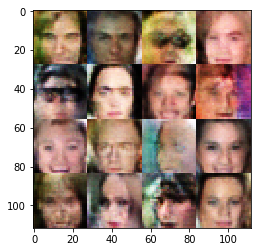

Epoch 2/3... Discriminator Loss: 0.6643... Generator Loss: 1.6460
Epoch 2/3... Discriminator Loss: 0.9936... Generator Loss: 0.6459
Epoch 2/3... Discriminator Loss: 0.8831... Generator Loss: 1.7547
Epoch 2/3... Discriminator Loss: 0.7749... Generator Loss: 1.0218
Epoch 2/3... Discriminator Loss: 0.6005... Generator Loss: 1.2586
Epoch 2/3... Discriminator Loss: 0.6201... Generator Loss: 1.6160
Epoch 2/3... Discriminator Loss: 1.6336... Generator Loss: 0.2840
Epoch 2/3... Discriminator Loss: 0.8687... Generator Loss: 0.8262
Epoch 2/3... Discriminator Loss: 0.7762... Generator Loss: 0.8804
Epoch 2/3... Discriminator Loss: 0.9888... Generator Loss: 2.2557


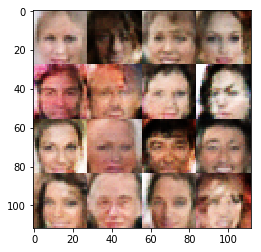

Epoch 2/3... Discriminator Loss: 1.1557... Generator Loss: 1.9749
Epoch 2/3... Discriminator Loss: 0.8343... Generator Loss: 0.9427
Epoch 2/3... Discriminator Loss: 0.7686... Generator Loss: 1.1459
Epoch 2/3... Discriminator Loss: 0.8941... Generator Loss: 0.9163
Epoch 2/3... Discriminator Loss: 1.0299... Generator Loss: 0.7268
Epoch 2/3... Discriminator Loss: 0.6697... Generator Loss: 1.8259
Epoch 2/3... Discriminator Loss: 0.8253... Generator Loss: 1.1682
Epoch 2/3... Discriminator Loss: 1.2102... Generator Loss: 0.5256
Epoch 2/3... Discriminator Loss: 0.7041... Generator Loss: 1.1958
Epoch 2/3... Discriminator Loss: 0.8771... Generator Loss: 1.3091


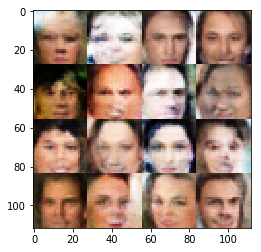

Epoch 2/3... Discriminator Loss: 0.7193... Generator Loss: 1.2532
Epoch 2/3... Discriminator Loss: 0.7296... Generator Loss: 1.4171
Epoch 2/3... Discriminator Loss: 0.7978... Generator Loss: 1.4649
Epoch 2/3... Discriminator Loss: 0.9895... Generator Loss: 0.6123
Epoch 2/3... Discriminator Loss: 0.8117... Generator Loss: 1.3547
Epoch 2/3... Discriminator Loss: 0.6520... Generator Loss: 1.1640
Epoch 2/3... Discriminator Loss: 0.7110... Generator Loss: 1.0437
Epoch 2/3... Discriminator Loss: 0.7979... Generator Loss: 1.7473
Epoch 2/3... Discriminator Loss: 0.7063... Generator Loss: 1.1095
Epoch 2/3... Discriminator Loss: 0.5469... Generator Loss: 1.7932


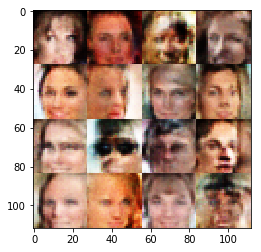

Epoch 2/3... Discriminator Loss: 0.7761... Generator Loss: 1.0562
Epoch 2/3... Discriminator Loss: 0.7858... Generator Loss: 1.8990
Epoch 2/3... Discriminator Loss: 0.8731... Generator Loss: 1.8830
Epoch 2/3... Discriminator Loss: 1.4892... Generator Loss: 0.3885
Epoch 2/3... Discriminator Loss: 0.6899... Generator Loss: 1.4668
Epoch 2/3... Discriminator Loss: 0.8150... Generator Loss: 0.9656
Epoch 2/3... Discriminator Loss: 0.7007... Generator Loss: 1.4032
Epoch 2/3... Discriminator Loss: 0.5905... Generator Loss: 1.3973
Epoch 2/3... Discriminator Loss: 0.6404... Generator Loss: 1.0923
Epoch 2/3... Discriminator Loss: 0.6747... Generator Loss: 1.5607


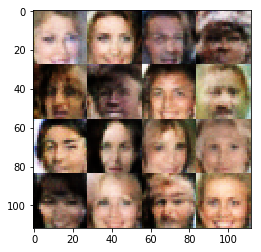

Epoch 2/3... Discriminator Loss: 0.8854... Generator Loss: 0.7585
Epoch 2/3... Discriminator Loss: 1.0730... Generator Loss: 0.5897
Epoch 2/3... Discriminator Loss: 0.7195... Generator Loss: 1.2560
Epoch 2/3... Discriminator Loss: 1.4545... Generator Loss: 0.3625
Epoch 2/3... Discriminator Loss: 0.6642... Generator Loss: 1.5573
Epoch 2/3... Discriminator Loss: 0.7022... Generator Loss: 1.9026
Epoch 2/3... Discriminator Loss: 0.7675... Generator Loss: 1.4187
Epoch 2/3... Discriminator Loss: 0.9926... Generator Loss: 0.6253
Epoch 2/3... Discriminator Loss: 0.6205... Generator Loss: 1.1874
Epoch 2/3... Discriminator Loss: 0.6988... Generator Loss: 1.7004


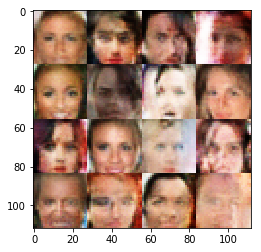

Epoch 2/3... Discriminator Loss: 0.9539... Generator Loss: 0.7168
Epoch 2/3... Discriminator Loss: 0.7105... Generator Loss: 1.3863
Epoch 2/3... Discriminator Loss: 1.1610... Generator Loss: 2.1776
Epoch 2/3... Discriminator Loss: 1.0677... Generator Loss: 0.6306
Epoch 2/3... Discriminator Loss: 0.8226... Generator Loss: 1.2819
Epoch 2/3... Discriminator Loss: 0.6291... Generator Loss: 1.5309
Epoch 2/3... Discriminator Loss: 0.7928... Generator Loss: 0.8994
Epoch 2/3... Discriminator Loss: 1.4475... Generator Loss: 0.3901
Epoch 2/3... Discriminator Loss: 0.6236... Generator Loss: 1.9099
Epoch 2/3... Discriminator Loss: 0.7970... Generator Loss: 1.5107


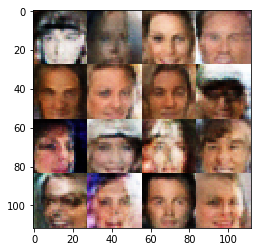

Epoch 2/3... Discriminator Loss: 0.8892... Generator Loss: 0.9416
Epoch 2/3... Discriminator Loss: 1.0605... Generator Loss: 0.6629
Epoch 2/3... Discriminator Loss: 1.0289... Generator Loss: 0.9136
Epoch 2/3... Discriminator Loss: 0.7865... Generator Loss: 1.2305
Epoch 2/3... Discriminator Loss: 0.7195... Generator Loss: 1.2532
Epoch 2/3... Discriminator Loss: 0.7262... Generator Loss: 1.6848
Epoch 2/3... Discriminator Loss: 0.8083... Generator Loss: 1.0468
Epoch 2/3... Discriminator Loss: 0.7990... Generator Loss: 0.8430
Epoch 2/3... Discriminator Loss: 0.8758... Generator Loss: 1.3196
Epoch 2/3... Discriminator Loss: 0.6767... Generator Loss: 1.7246


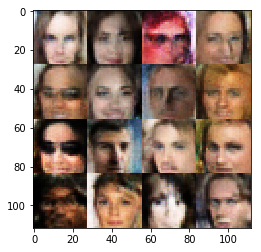

Epoch 2/3... Discriminator Loss: 1.0115... Generator Loss: 0.6836
Epoch 2/3... Discriminator Loss: 1.2141... Generator Loss: 0.5171
Epoch 2/3... Discriminator Loss: 0.9860... Generator Loss: 1.5223
Epoch 2/3... Discriminator Loss: 0.7652... Generator Loss: 1.1910
Epoch 2/3... Discriminator Loss: 0.7113... Generator Loss: 1.1600
Epoch 2/3... Discriminator Loss: 0.7327... Generator Loss: 1.4445
Epoch 3/3... Discriminator Loss: 1.0642... Generator Loss: 0.5860
Epoch 3/3... Discriminator Loss: 1.0591... Generator Loss: 0.6427
Epoch 3/3... Discriminator Loss: 0.7441... Generator Loss: 1.1680
Epoch 3/3... Discriminator Loss: 0.6626... Generator Loss: 1.1151


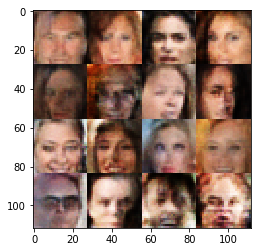

Epoch 3/3... Discriminator Loss: 0.7628... Generator Loss: 1.6460
Epoch 3/3... Discriminator Loss: 0.4372... Generator Loss: 1.6658
Epoch 3/3... Discriminator Loss: 0.6627... Generator Loss: 1.8166
Epoch 3/3... Discriminator Loss: 0.7274... Generator Loss: 2.2706
Epoch 3/3... Discriminator Loss: 0.8484... Generator Loss: 1.0088
Epoch 3/3... Discriminator Loss: 0.9262... Generator Loss: 0.7560
Epoch 3/3... Discriminator Loss: 0.7487... Generator Loss: 1.0273
Epoch 3/3... Discriminator Loss: 0.7402... Generator Loss: 1.7736
Epoch 3/3... Discriminator Loss: 1.0024... Generator Loss: 0.7288
Epoch 3/3... Discriminator Loss: 0.8855... Generator Loss: 0.7876


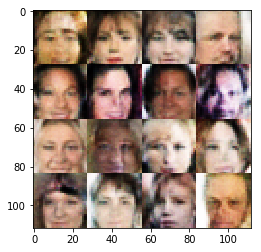

Epoch 3/3... Discriminator Loss: 0.8259... Generator Loss: 1.1828
Epoch 3/3... Discriminator Loss: 0.8551... Generator Loss: 0.8931
Epoch 3/3... Discriminator Loss: 0.6785... Generator Loss: 1.6768
Epoch 3/3... Discriminator Loss: 0.7198... Generator Loss: 0.9007
Epoch 3/3... Discriminator Loss: 0.8468... Generator Loss: 1.0403
Epoch 3/3... Discriminator Loss: 0.7604... Generator Loss: 1.7908
Epoch 3/3... Discriminator Loss: 0.7201... Generator Loss: 1.1264
Epoch 3/3... Discriminator Loss: 0.8850... Generator Loss: 1.0116
Epoch 3/3... Discriminator Loss: 0.9198... Generator Loss: 0.7617
Epoch 3/3... Discriminator Loss: 0.8570... Generator Loss: 0.9022


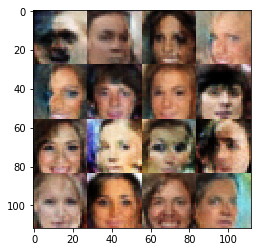

Epoch 3/3... Discriminator Loss: 0.6005... Generator Loss: 1.6546
Epoch 3/3... Discriminator Loss: 0.8311... Generator Loss: 0.8461
Epoch 3/3... Discriminator Loss: 0.7925... Generator Loss: 1.5460
Epoch 3/3... Discriminator Loss: 0.7924... Generator Loss: 0.8180
Epoch 3/3... Discriminator Loss: 2.8591... Generator Loss: 4.1168
Epoch 3/3... Discriminator Loss: 0.7515... Generator Loss: 1.3774
Epoch 3/3... Discriminator Loss: 1.0600... Generator Loss: 2.3910
Epoch 3/3... Discriminator Loss: 0.8373... Generator Loss: 1.0233
Epoch 3/3... Discriminator Loss: 0.8904... Generator Loss: 0.8029
Epoch 3/3... Discriminator Loss: 0.7556... Generator Loss: 0.8971


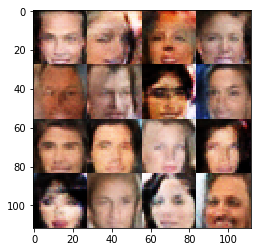

Epoch 3/3... Discriminator Loss: 1.1252... Generator Loss: 0.7386
Epoch 3/3... Discriminator Loss: 0.9427... Generator Loss: 0.6848
Epoch 3/3... Discriminator Loss: 0.8233... Generator Loss: 0.8795
Epoch 3/3... Discriminator Loss: 0.7060... Generator Loss: 1.3755
Epoch 3/3... Discriminator Loss: 0.6517... Generator Loss: 1.1525
Epoch 3/3... Discriminator Loss: 0.7453... Generator Loss: 1.4716
Epoch 3/3... Discriminator Loss: 1.1881... Generator Loss: 0.7413
Epoch 3/3... Discriminator Loss: 0.8227... Generator Loss: 1.1520
Epoch 3/3... Discriminator Loss: 0.7548... Generator Loss: 1.4042
Epoch 3/3... Discriminator Loss: 1.0749... Generator Loss: 0.6165


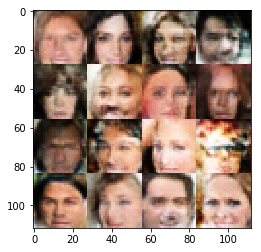

Epoch 3/3... Discriminator Loss: 0.7488... Generator Loss: 1.5797
Epoch 3/3... Discriminator Loss: 0.6620... Generator Loss: 1.5011
Epoch 3/3... Discriminator Loss: 0.8647... Generator Loss: 0.8502
Epoch 3/3... Discriminator Loss: 0.6842... Generator Loss: 1.7985
Epoch 3/3... Discriminator Loss: 1.4947... Generator Loss: 0.3427
Epoch 3/3... Discriminator Loss: 0.9322... Generator Loss: 0.8228
Epoch 3/3... Discriminator Loss: 0.6564... Generator Loss: 1.4950
Epoch 3/3... Discriminator Loss: 0.6954... Generator Loss: 1.6687
Epoch 3/3... Discriminator Loss: 1.2515... Generator Loss: 0.4837
Epoch 3/3... Discriminator Loss: 0.9583... Generator Loss: 0.6715


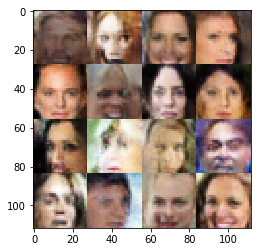

Epoch 3/3... Discriminator Loss: 0.8331... Generator Loss: 0.9791
Epoch 3/3... Discriminator Loss: 0.6271... Generator Loss: 1.3318
Epoch 3/3... Discriminator Loss: 0.8090... Generator Loss: 0.9293
Epoch 3/3... Discriminator Loss: 0.9423... Generator Loss: 1.0340
Epoch 3/3... Discriminator Loss: 0.5885... Generator Loss: 1.2230
Epoch 3/3... Discriminator Loss: 0.7913... Generator Loss: 1.0279
Epoch 3/3... Discriminator Loss: 1.3114... Generator Loss: 2.0764
Epoch 3/3... Discriminator Loss: 0.7593... Generator Loss: 1.2020
Epoch 3/3... Discriminator Loss: 0.8086... Generator Loss: 0.8770
Epoch 3/3... Discriminator Loss: 0.9168... Generator Loss: 0.7415


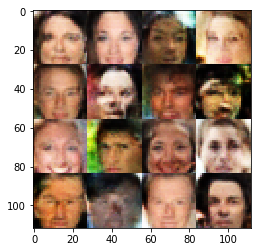

Epoch 3/3... Discriminator Loss: 0.7996... Generator Loss: 1.1555
Epoch 3/3... Discriminator Loss: 0.9334... Generator Loss: 0.7229
Epoch 3/3... Discriminator Loss: 1.8644... Generator Loss: 0.2782
Epoch 3/3... Discriminator Loss: 0.7790... Generator Loss: 1.3745
Epoch 3/3... Discriminator Loss: 0.7045... Generator Loss: 1.1365
Epoch 3/3... Discriminator Loss: 0.6404... Generator Loss: 1.4027
Epoch 3/3... Discriminator Loss: 0.8555... Generator Loss: 1.0022
Epoch 3/3... Discriminator Loss: 0.7733... Generator Loss: 1.5693
Epoch 3/3... Discriminator Loss: 0.8932... Generator Loss: 0.9317
Epoch 3/3... Discriminator Loss: 0.9240... Generator Loss: 0.9665


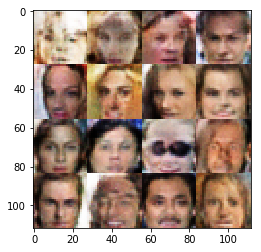

Epoch 3/3... Discriminator Loss: 1.0214... Generator Loss: 0.6667
Epoch 3/3... Discriminator Loss: 0.9370... Generator Loss: 0.7539
Epoch 3/3... Discriminator Loss: 0.6364... Generator Loss: 1.2045
Epoch 3/3... Discriminator Loss: 0.8340... Generator Loss: 0.8105
Epoch 3/3... Discriminator Loss: 1.0754... Generator Loss: 1.8635
Epoch 3/3... Discriminator Loss: 0.6273... Generator Loss: 1.2092
Epoch 3/3... Discriminator Loss: 0.6789... Generator Loss: 1.5569
Epoch 3/3... Discriminator Loss: 0.7077... Generator Loss: 1.1647
Epoch 3/3... Discriminator Loss: 0.8093... Generator Loss: 1.0916
Epoch 3/3... Discriminator Loss: 1.0463... Generator Loss: 0.6424


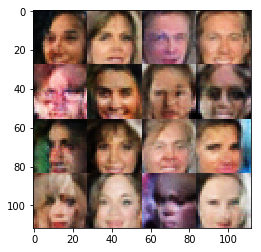

Epoch 3/3... Discriminator Loss: 1.0057... Generator Loss: 0.6036
Epoch 3/3... Discriminator Loss: 0.7791... Generator Loss: 0.9390
Epoch 3/3... Discriminator Loss: 0.8738... Generator Loss: 1.2007
Epoch 3/3... Discriminator Loss: 0.6135... Generator Loss: 1.2343
Epoch 3/3... Discriminator Loss: 0.6912... Generator Loss: 1.0472
Epoch 3/3... Discriminator Loss: 0.9464... Generator Loss: 0.7381
Epoch 3/3... Discriminator Loss: 0.7346... Generator Loss: 1.0833
Epoch 3/3... Discriminator Loss: 0.9928... Generator Loss: 0.6506
Epoch 3/3... Discriminator Loss: 1.0652... Generator Loss: 0.5948
Epoch 3/3... Discriminator Loss: 1.4349... Generator Loss: 2.8209


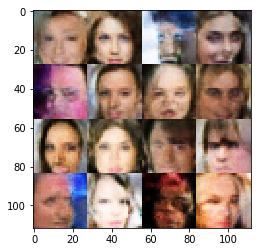

Epoch 3/3... Discriminator Loss: 0.7111... Generator Loss: 1.3251
Epoch 3/3... Discriminator Loss: 1.0663... Generator Loss: 2.0411
Epoch 3/3... Discriminator Loss: 0.9693... Generator Loss: 0.7066
Epoch 3/3... Discriminator Loss: 0.9158... Generator Loss: 0.7786
Epoch 3/3... Discriminator Loss: 0.9151... Generator Loss: 0.8186
Epoch 3/3... Discriminator Loss: 0.7741... Generator Loss: 1.2984
Epoch 3/3... Discriminator Loss: 0.7092... Generator Loss: 1.4355
Epoch 3/3... Discriminator Loss: 0.8716... Generator Loss: 1.0639
Epoch 3/3... Discriminator Loss: 0.7564... Generator Loss: 0.8922
Epoch 3/3... Discriminator Loss: 1.1223... Generator Loss: 0.5661


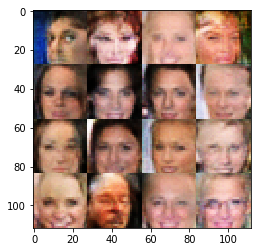

Epoch 3/3... Discriminator Loss: 0.7801... Generator Loss: 1.8562
Epoch 3/3... Discriminator Loss: 0.8535... Generator Loss: 0.7962
Epoch 3/3... Discriminator Loss: 0.8667... Generator Loss: 2.1202


In [ ]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 3

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.